In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
from Functions import *
from tqdm import tqdm

# Import and prepare data

In [2]:
infected = pd.read_csv('South_Africa_save/South_Africa_infected.csv')
removed = pd.read_csv('South_Africa_save/South_Africa_removed.csv')
confirmed = pd.read_csv('South_Africa_save/South_Africa_confirmed.csv')

In [3]:
it=infected.to_numpy()
rt=removed.to_numpy()
ct=confirmed.to_numpy()

In [4]:
split=[60,313,473]

i1=it[split[0]:split[1]]
r1=rt[split[0]:split[1]]
i2=it[split[1]:split[2]]
r2=rt[split[1]:split[2]]
i3=it[split[2]:]
r3=it[split[2]:]

N1=ct[split[1]]
N2=ct[split[2]]
N3=ct[-1]

In [5]:
ii1=i1.reshape((i1.shape[0],))
rr1=r1.reshape((r1.shape[0],))
ii2=i2.reshape((i2.shape[0],))
rr2=r2.reshape((r2.shape[0],))
ii3=i3.reshape((i3.shape[0],))
rr3=r3.reshape((r3.shape[0],))

In [6]:
N=58560000
inf1=ii1/N
rem1=rr1/N
inf2=ii2/N
rem2=rr2/N
inf3=ii3/N
rem3=rr3/N

# Rescale policies

For different policies, the scales are different. See https://ourworldindata.org/policy-responses-covid

In [7]:
policy = pd.read_csv('South_Africa_save/South_Africa_policy_use.csv')

In [8]:
policy.columns

Index(['Day', 'testing_policy', 'contact_tracing', 'vaccination_policy',
       'debt_relief', 'facial_coverings', 'income_support',
       'restrictions_internal_movements', 'international_travel_controls',
       'public_information_campaigns', 'cancel_public_events',
       'restriction_gatherings', 'close_public_transport', 'school_closures',
       'stay_home_requirements', 'workplace_closures'],
      dtype='object')

In [9]:
po1=policy.copy()

In [10]:
po1['testing_policy']=policy['testing_policy']/3
po1['contact_tracing']=policy['contact_tracing']/2
po1['vaccination_policy']=policy['vaccination_policy']/5
po1['debt_relief']=policy['debt_relief']/2
po1['facial_coverings']=policy['facial_coverings']/4
po1['income_support']=policy['income_support']/2
po1['restrictions_internal_movements']=policy['restrictions_internal_movements']/2
po1['international_travel_controls']=policy['international_travel_controls']/4
po1['public_information_campaigns']=policy['public_information_campaigns']/2
po1['cancel_public_events']=policy['cancel_public_events']/2
po1['restriction_gatherings']=policy['restriction_gatherings']/4
po1['close_public_transport']=policy['close_public_transport']/2
po1['school_closures']=policy['school_closures']/3
po1['stay_home_requirements']=policy['stay_home_requirements']/3
po1['workplace_closures']=policy['workplace_closures']/3

In [11]:
po2=po1.drop(['Day'],axis=1)

In [12]:
p1=po2[split[0]:split[1]]
p2=po2[split[1]:split[2]]
p3=po2[split[2]:]

# Fit SIR models, and abtain all data points for neural network training

In [26]:
# With in a peak, train from 30 days or s0, and get a data point for every day.
def one_peak(inf,rem,po,start=20):
    duration = inf.shape[0]
    results=[]
    x_train=[]
    index=[]
    for i in tqdm(range(start, duration)):
        result=run(inf[:i],rem[:i])
        reletive_error=[]
        for name, param in result[2].params.items():
            reletive_error.append(param.stderr/param.value)
#         print(reletive_error)
        if np.all(np.array(reletive_error[3:]) < 0.05):
#             print(reletive_error)
            results.append(result)
            x_train.append(po[:i].mean().to_numpy())
            index.append(i)
    return results, x_train, index

In [27]:
results, x_train, index=one_peak(inf1,rem1,p1,start=20)
results2, x_train2, index2=one_peak(inf2,rem2,p2,start=20)
results3, x_train3, index3=one_peak(inf3,rem3,p3,start=20)

  0%|                                                                                          | 0/233 [00:00<?, ?it/s]<ipython-input-26-24e4eec2ad61>:11: RuntimeWarning: invalid value encountered in double_scalars
  reletive_error.append(param.stderr/param.value)
100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 29.06it/s]


In [28]:
len(x_train),len(x_train2),len(x_train3)

(151, 116, 15)

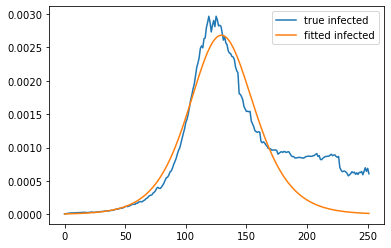

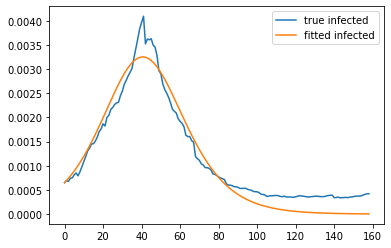

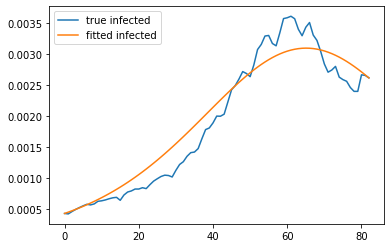

In [30]:
plot_fit(results[-1],inf1[:index[-1]])
plot_fit(results2[-1],inf2[:index2[-1]])
plot_fit(results3[-1],inf3[:index3[-1]])

# Prepare data for neural network

In [31]:
df_x1=pd.DataFrame(x_train)
df_x2=pd.DataFrame(x_train2)
df_x3=pd.DataFrame(x_train3)

In [34]:
df_x=df_x1.append(df_x2)
df_x=df_x.append(df_x3)

In [35]:
df_x.to_csv('South_Africa_save/x_train.csv')

In [36]:
def get_pa(results):
    beta=[]
    gamma=[]
    for result in results:
        beta.append(result[2].params['beta'].value)
        gamma.append(result[2].params['gamma'].value)
    return beta, gamma

In [37]:
beta1, gamma1 = get_pa(results)
beta2, gamma2 = get_pa(results2)
beta3, gamma3 = get_pa(results3)
df_y1=pd.DataFrame({'beta':beta1,'gamma':gamma1})
df_y2=pd.DataFrame({'beta':beta2,'gamma':gamma2})
df_y3=pd.DataFrame({'beta':beta3,'gamma':gamma3})
df_y=df_y1.append(df_y2)
df_y=df_y.append(df_y3)

In [38]:
df_y.to_csv('South_Africa_save/y_train.csv')

In [39]:
index=np.array(index)
index2=np.array(index2)
index3=np.array(index3)

In [40]:
np.save('South_Africa_save/fit_index1.npy',index)
np.save('South_Africa_save/fit_index2.npy',index2)
np.save('South_Africa_save/fit_index3.npy',index3)